# Fundamentals of Finite Volume for TDEM Simulations

```{admonition} Introductory notebook
:class: hint
This tutorial teaches basic functionality within SimPEG and is a good entry point for new users.
```

```{admonition} Light-weight notebook
:class: hint
This tutorial requires minimal computational resources and can be executed quickly in the background while other computer processes are running.
```

```{admonition} Prerequisite Tutorials
:class: note
[1D Forward Simulation for a Single Sounding](fwd_tdem_1d.ipynb)
```

**Author:** Devin C. Cowan

</br>

**Keywords:** finite volume fundamentals, TDEM, forward simulation, time discretization, mesh discretization.

</br>

**Summary:** Successful forward simulation of TDEM data using mimetic finite volume requires reasonable values for a multitude of input parameters. More specifically, the parameters which determine how our numerical scheme is discretized in space and in time. When choosing parameters values for the TDEM forward simulation, we aim find an optimum balance between:

* numerical accuracy, and
* required computational resources (e.g. run-time, memory)

In this tutorial, we do not focus on the syntax for generating and organizing the SimPEG objects used in TDEM forward simulations. Survey design for specific geometries are discussed in separate tutorials. However, we assume the user has worked through the [1D Forward Simulation for a Single Sounding](fwd_tdem_1d.ipynb) tutorial and already familiar with generating waveform, source, receiver and survey objects.

Here, we demonstrate how discretization in space and in time impacts TDEM forward simulations. Results are used to develop guidelines that are applicable in most cases. To limit the computation time required to run the tutorial, all simulations are performed on a [Cylindrical Mesh](myst:discretize#discretize.CylindricalMesh). However, the knowledge gained here can be applied regardless of the mesh type (e.g. [Tensor Mesh](myst:discretize#discretize.TensorMesh), [Tree Mesh](myst:discretize#discretize.TreeMesh)).

</br>

**Learning Objectives:**

- Using observation times and subsurface conductivity to generate an appropriate mesh.
- Defining the time discretization during the off-time.
- Defining the time discretization during a waveform's on-time.

## Importing Modules

Here, we import all of the functionality required to run the notebook for the tutorial exercise. All of the functionality specific to TDEM is imported from [SimPEG.electromagnetics.time_domain](myst:SimPEG#SimPEG.electromagnetics.time_domain). We also import some useful utility functions from [SimPEG.utils](myst:SimPEG#SimPEG.utils).

In [1]:
# SimPEG functionality
import SimPEG.electromagnetics.time_domain as tdem
from SimPEG import maps

# discretize functionality
from discretize import CylindricalMesh, TensorMesh
from discretize.utils import mkvc

# Common Python functionality
import numpy as np
from scipy.constants import mu_0
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update({"font.size": 14})

## Defining the Simulation Geometry

Here, we define the problem geometry that will be used throughout the tutorial. The problem geometry consists of a horizontal circular transmitter loop with a radius of 25 m, located on the Earth's surface. Data are simulated at the center of the loop at a set of logarithmically-spaced time channels. The subsurface electrical conductivity is characterized by a 1e-2 S/m halfspace.

In [2]:
# Source properties
source_location = np.array([0.0, 0.0, 0.0])  # (3, ) numpy.array_like
source_orientation = "z"                     # "x", "y" or "z"
source_current = 1.0                         # maximum on-time current (A)
source_radius = 25.0                         # source loop radius (m)

# Receiver properties
receiver_locations = np.array([0.0, 0.0, 0.0])  # or (N, 3) numpy.ndarray
receiver_orientation = "z"                      # "x", "y" or "z"
time_channels = np.logspace(-5, -3, 21)         # time channels (s)

# Model properties
halfspace_conductivity = 1e-2  # Halfspace conductivity (S/m)

## Defining Some Tutorial Functions

Here, we define several functions that will be used to generate objects throughout the tutorial when needed.

### Generate the Survey

For the [waveform object](myst:SimPEG#SimPEG.electromagnetics.time_domain.sources.BaseWaveform) provided, this function generates the [TDEM survey object](myst:SimPEG#SimPEG.electromagnetics.time_domain.survey.Survey) for our problem geometry when called.

In [3]:
def generate_survey(waveform_object):
    
    # Define receiver
    receiver_list = [
        tdem.receivers.PointMagneticFluxTimeDerivative(
            receiver_locations, time_channels, orientation=receiver_orientation
        )
    ]
    
    # Define loop source
    source_list = [
        tdem.sources.CircularLoop(
            receiver_list=receiver_list,
            location=source_location,
            waveform=waveform_object,
            current=source_current,
            radius=source_radius,
        )
    ]
    
    return tdem.Survey(source_list)

### Generate the Mesh, Model and Mapping

For the minimum cell size *dh*, minimum diffusion distance *d_min* and maximum diffusion distance *d_max*, this function generates a [Cylindrical Mesh](myst:discretize#discretize.CylindricalMesh).

In [4]:
def generate_discretization(dh, d_min, d_max):
    
    # Number of core mesh cells
    n_core = np.floor(8 * d_min / dh)
    
    # Number of padding cells
    n_pad = 1
    while sum(dh * 1.5**np.arange(n_pad)) < 2 * d_max:
        n_pad += 1
    
    # Radial and vertical discretization
    hr = [(dh, n_core), (dh, n_pad, 1.2)]
    hz = [(dh, n_pad, -1.2), (dh, 2*n_core), (dh, n_pad, 1.2)]
    
    # Generate mesh
    mesh = CylindricalMesh([hr, 1, hz], x0="00C")
    
    # Active cells
    active_cells = mesh.cell_centers[:, -1] < 0.
    
    # Halfspace conductivity model
    model = halfspace_conductivity * np.ones(np.sum(active_cells))
    
    # Mapping from conductivity model to mesh
    mapping = maps.InjectActiveCells(mesh, active_cells, 1e-8)
    
    return mesh, model, mapping

## Part 1: Discretization in Space (cell size)

Here, we investigate the impact of minimum cell size on the accuracy of the forward simulation. It is obvious that finer cells will reduce the error in the numerical forward simulation. However, overly fine discretization can produce meshes that make the numerical forward simulation untenable. For instance, by decreasing the widths of the cells in a mesh by a factor of 2, the number of cells in a 2D tensor mesh will increase by a factor of 4, and the number of cells in a 3D tensor mesh will increase by a factor of 8. So when choosing the parameters that define the mesh, we aim find an optimum balance between:

* numerical accuracy, and
* required computational resources (e.g. run-time, memory)

For the problem geometry described in the introduction, we simulate db/dt at the source loop's center for a step-off excitation. When generating an appropriate mesh, we consider the [diffusion distance](https://em.geosci.xyz/content/maxwell1_fundamentals/transient_planewaves_homogeneous/peakdistance.html):

$$
d = \sqrt{\frac{2 t}{\mu \sigma}} \approx 1260 \sqrt{\frac{t}{\sigma}}
$$

which defines the distance the peak amplitude of a planewave has traveled within a homogeneous medium at time *t* after an initial step excitation.

From the figure below, we can see the propagation and diffusion of the TDEM signal over time. At early times, the signal is compact and the diffusion distance is small. And to model the physics accurately at these times, finer spatial sampling (i.e. discretization) within the region of the signal is required. At later times, the diffusion distance is larger and the signal has diffused and become smooth. As a result, the distance between spatially sampled points (i.e. discretization) at these times can be larger while still modeling the physics accurately.

```{figure} ../../assets/website_images/diffusion_distance.png
:width: 800px
:align: center

Propagation and diffusion of a planewave within a homogeneous medium.
```

It is important the note that the diffusion distance within conductive media is smaller at time *t* because wave propagation and diffusion occurs more slowly. And thus conductive structures necessitates finer discretization.

**Standard Approach:** 

1. Use the earliest time channel in the survey and the highest conductivity used to define your geophysical scenario to compute the minimum diffusion distance, i.e.:

$$
d_{min} \approx 1260 \sqrt{\frac{t_{min}}{\sigma_{max}}}
$$

2. Use the latest time channel and host conductivity to compute the largest diffusion distance, i.e.:

$$
d_{max} \approx 1260 \sqrt{\frac{t_{max}}{\sigma_{host}}}
$$

3. Generate the mesh using the following guidelines:

    - The minimum cell size **must** be equal or smaller than the minimum skin depth; i.e. $dh \leq d_{min}$.
    - There should be several cells between any controlled source and its receiver(s).
    - Further away from any controlled source, the fields are smoother and we can use a coarser discretization. However, we should not coarsen too quickly. For tensor meshes, the widths of adjacent cells should not increase by more than a factor of 1.5. For tree meshes, you should have a layer at least 4 cells thick before increasing the cell size again.
    - Within the core region of your mesh, cell dimensions should never exceed an aspect ratio of 2:1.
    - The padding region between the survey and the edge of the mesh **must** be 2-3 times the largest diffusion distance. This is done to respect the natural boundary conditions impose on the numerical solution.

### Compute the Diffusion Distances

Here, we compute the minimum and maximum diffusion distances for the forward simulation. Here, we only have to consider the diffusion distances for a halfspace.

In [5]:
diffusion_distances = 1260 * np.sqrt(time_channels / halfspace_conductivity)
d_min = diffusion_distances.min()
d_max = diffusion_distances.max()
print('DIFFUSION DISTANCES: {}'.format(np.round(diffusion_distances, 1)))

DIFFUSION DISTANCES: [ 39.8  44.7  50.2  56.3  63.1  70.9  79.5  89.2 100.1 112.3 126.  141.4
 158.6 178.  199.7 224.1 251.4 282.1 316.5 355.1 398.4]


### Define Minimum Cell Widths

To validate the standard approach, forward simulations are performed using minimum cell sizes equal to 4, 2, 1, 0.5 and 0.25 times the smallest diffusion distance. Here, we define the list containing the minimum cell size used in each forward simulation.

In [6]:
size_factor = [4., 2., 1., 0.5, 0.25]
dh_min = [c * d_min for c in size_factor]

### Define the Waveform

Here, we define the [stepoff waveform object](myst:SimPEG#SimPEG.electromagnetics.time_domain.sources.StepOffWaveform) that is used in the forward simulations.

In [7]:
stepoff_waveform = tdem.sources.StepOffWaveform(off_time=0.0)

### Numerical Solution

Here, we perform the forward simulation for a set of minimum cell widths and store the predicted data in list. For each case, we must:

* define a new mesh, model and mapping.
* define the simulation.
* predict data for the halfspace conductivity model.

We have automatically set a reasonable time-discretization for the problem. The impact of time-discretization is demonstrated in Part 2.

In [8]:
dpred_1 = []

for dh in dh_min:
    
    # Generate mesh, model and mapping
    mesh, model, mapping = generate_discretization(dh, d_min, d_max)
    
    # Define the simulation
    simulation = tdem.simulation.Simulation3DElectricField(
        mesh,
        survey=generate_survey(stepoff_waveform),
        sigmaMap=mapping,
        time_steps=[(5e-07, 40), (2.5e-06, 40), (1.25e-05, 81)]
    )
    
    # Simulate the data
    dpred_1.append(simulation.dpred(model))
    
    print('N_CELLS: {}'.format(mesh.nC))

N_CELLS: 72
N_CELLS: 162
N_CELLS: 392
N_CELLS: 1152
N_CELLS: 3528


### Analytic 1D Solution

Here, the [Simulation1DLayered](myst:SimPEG#SimPEG.electromagnetics.time_domain.Simulation1DLayered) simulation class is used to simulate the analytic solution to our problem.

In [9]:
simulation_1d = tdem.simulation_1d.Simulation1DLayered(
    survey=generate_survey(stepoff_waveform),
    thicknesses=[],
    sigmaMap=maps.IdentityMap(nP=1)
)

dtrue_stepoff = simulation_1d.dpred(np.array([halfspace_conductivity]))

### Results

Here, we plot the analytic 1D solution and the numerical solutions using different minimum cell widths. As we can see, sufficient numerical accuracy is obtained when the minimum cell width is equal to or smaller than the minimum diffusion distance.

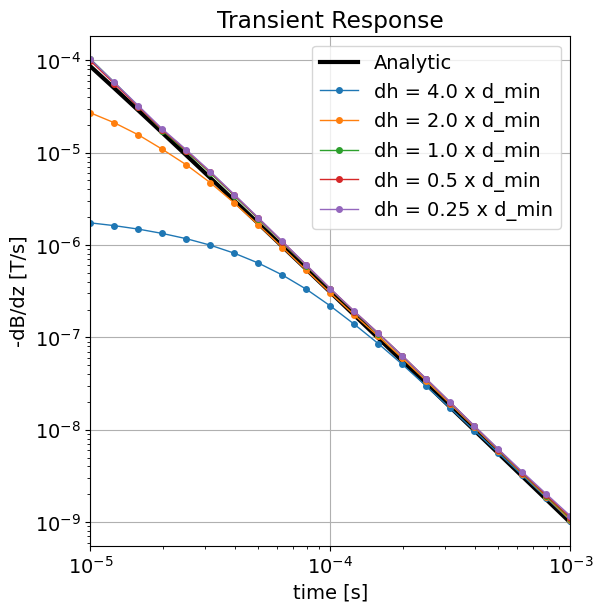

In [10]:
fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.85])
ax1.loglog(time_channels, -dtrue_stepoff, 'k', lw=3)
for d in dpred_1:
    ax1.loglog(time_channels, -d, '-o', lw=1, markersize=4)
ax1.set_xlim((np.min(time_channels), np.max(time_channels)))
ax1.grid()
ax1.set_xlabel("time [s]")
ax1.set_ylabel("-dB/dz [T/s]")
ax1.set_title("Transient Response")
ax1.legend(['Analytic'] + ['dh = {} x d_min'.format(c) for c in size_factor])
plt.show()

## Part 2: Discretization in Time (off-time)

In SimPEG, time-stepping is currently carried out using [Backward Euler](https://en.wikipedia.org/wiki/Backward_Euler_method). Not only is this method stable when stepping forward in time, it only requires the storage of a single factorization of a matrix inverse for each unique step length.

Here, we investigate the impact of time-step size on the accuracy of the forward simulation. When choosing a time-stepping scheme, our goals are to:

* Minimize the number of time-steps
* Minimize the number of unique step lengths

Although smaller time-steps will reduce the error in the numerical forward simulation, a solve is required at every time step. Run-times can therefore become very large when the step-size is too small. Since the Earth's TDEM response is characterized by a set of exponential decays, we can reduced the total number of time-steps by using smaller time-steps at early times and larger time-steps at later times. However, the inverse of a linear system must be factored and stored for each unique time-step. Not only does each factorization take significant time, it may also require significant computer memory.

**Standard Approach:** Assume the off-time begins at t = 0 s.

1. Consider your earliest time channel. The minimum time-step length should be 5-10\% of the earliest time channel. Use this step lenght until just after your first time channel.
2. Increase the time-step length by a factor of 3-6; using a larger factor will produce artifacts. Use this step length over the next decade of time channels.
3. Repeat until you have at least 1 time step beyond your latest time channel.

If applied correctly, and you have time channels spanning *N* orders of magnitude, this will result in *N+1* unique step lengths. Our suggested approach generally strikes a reasonable balance between limiting the number of time-steps and the number of unique time-step lengths.

### Define Minimum Time-Step Lengths

To validate the standard approach, forward simulations are performed using various minimum time-step lengths. Where $t_{min}$ is the earliest time channel, we test minimum time-step lengths of:

$$
dt_{min} = \left \{ \frac{t_{min}}{2.5}, \; \frac{t_{min}}{5}, \; \frac{t_{min}}{10}, \; \frac{t_{min}}{20}, \; \frac{t_{min}}{40}, \; \right \}
$$

At each decade, we increase the time-step size by a factor of 5.

In [11]:
t_min = time_channels.min()  # Earliest time channel

size_factor = [5, 10, 20, 40, 80]
dt_min = [t_min/c for c in size_factor]  # minimum time-step lengths

### Numerical Solution

Here, we perform the forward simulation for a set of minimum time-step lengths and store the predicted data in list. In accordance with our findings in Part 1, we use a minimum cell size equal to the smallest diffusion distance.

In [12]:
# Store the predicted data and time steps
dpred_2 = []
simulation_times = []

# Define the mesh, model and mapping
mesh, model, mapping = generate_discretization(d_min, d_min, d_max)

for dt in dt_min:
    
    # Define the simulation
    simulation = tdem.simulation.Simulation3DElectricField(
        mesh,
        survey=generate_survey(stepoff_waveform),
        sigmaMap=mapping,
    )
    
    # Set the time steps
    time_steps = [
        (dt, int(1.05*t_min/dt)),
        (5*dt, int(10*t_min/(5*dt) + 1)),
        (25*dt, int(100*t_min/(25*dt) + 1))
    ]
    simulation.time_steps = time_steps
    
    # Store the time steps
    simulation_times.append(simulation.times[1:])
    
    # Simulate the data
    dpred_2.append(simulation.dpred(model))
    
    print('N_TIMES: {}'.format(simulation.nT))

N_TIMES: 35
N_TIMES: 70
N_TIMES: 141
N_TIMES: 282
N_TIMES: 564


### Results

Below, we see that a minimum time-step length smaller than $\frac{t_{min}}{20}$ is required to produce reasonable accuracy.

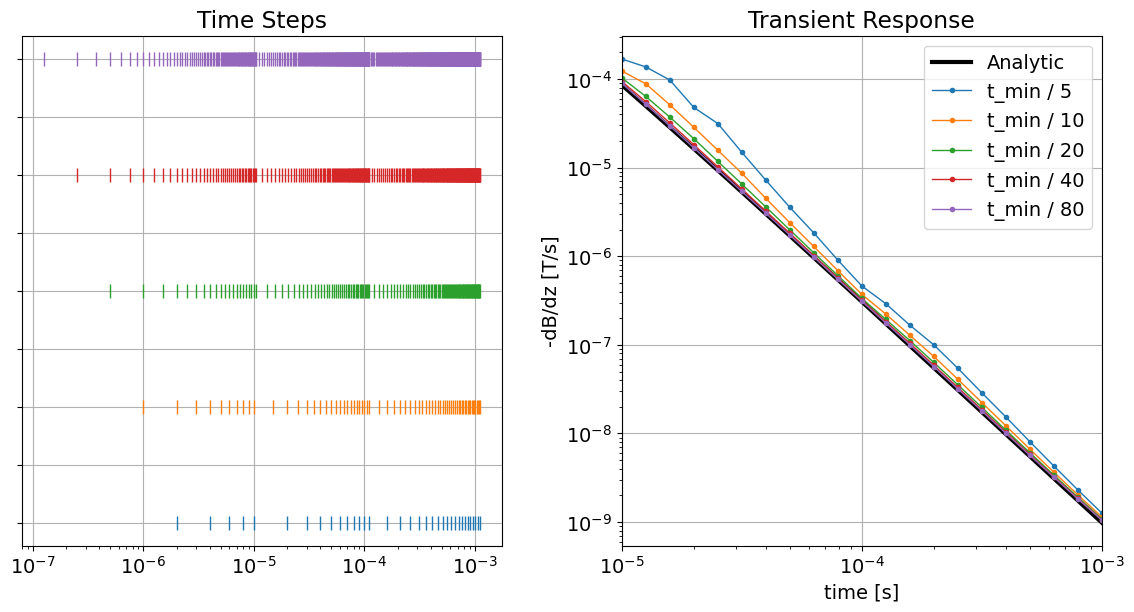

In [13]:
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_axes([0.05, 0.1, 0.4, 0.85])
for ii, tvec in enumerate(simulation_times):
    ax1.semilogx(tvec, ii*np.ones_like(tvec), '|', markersize=10)
ax1.set_yticklabels([])
ax1.set_title('Time Steps')
ax1.grid()

ax2 = fig.add_axes([0.55, 0.1, 0.4, 0.85])
ax2.loglog(time_channels, -dtrue_stepoff, 'k', lw=3)
for d in dpred_2:
    ax2.loglog(time_channels, -d, '-o', lw=1, markersize=3)
ax2.set_xlim((np.min(time_channels), np.max(time_channels)))
ax2.grid()
ax2.set_xlabel("time [s]")
ax2.set_ylabel("-dB/dz [T/s]")
ax2.set_title("Transient Response")
ax2.legend(['Analytic'] + ['t_min / {}'.format(c) for c in size_factor])
plt.show()

## Part 3: Time-Discretization (on-time)

For purely academic exercises, we frequently simulate the Earth's response to step excitation. In practice, controlled EM sources have time-dependent waveforms. In order to accurately simulated the Earth's response, we must appropriately discretize the source waveform before the off-time.

* When discretizing a piecewise linear portion of a current waveform, the time-step length used must be sufficiently smaller than the length of the segment.
* Discretization just before shut-off is more important than much earlier due to the nature of the Earth's impulse response.

### Defining the On-Time and Its Time-Steps

In [14]:
t0 = -1e-3
n_on_time_steps = [10, 20, 40, 80, 160]
on_time_steps_list = [(np.abs(t0)/n, n) for n in n_on_time_steps]

### Defining the Waveforms

Here, we define the waveforms that will be used to simulate data in this part of the tutorial. They are a [triangular waveform](myst:SimPEG#SimPEG.electromagnetics.time_domain.sources.TriangularWaveform) and an [exponential ranp-on linear ramp-off waveform](myst:SimPEG#SimPEG.electromagnetics.time_domain.sources.ExponentialWaveform). As we will see, the current in the triangular waveform is piecewise linear and easy to discretize with very few time-steps. Whereas the ramp-off in the latter waveform happens very quickly and cannot be discretized with very large time-steps. 

In [15]:
triangular_waveform = tdem.sources.TriangularWaveform(
    start_time=t0, peak_time=t0/2, off_time=0.0
)

In [16]:
exponential_waveform = tdem.sources.ExponentialWaveform(
    start_time=t0, peak_time=t0/40
)

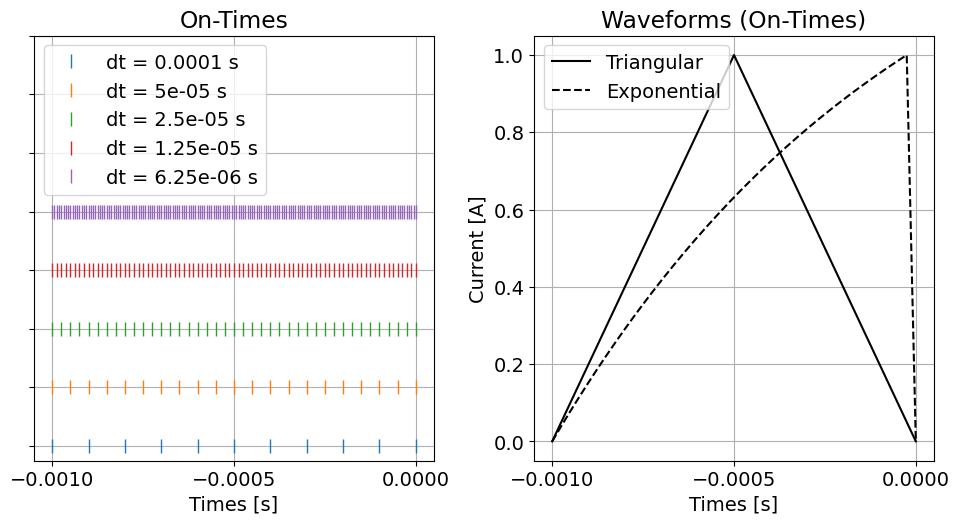

In [17]:
fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_axes([0.05, 0.1, 0.4, 0.85])
for ii in range(len(on_time_steps_list)):
    t_mesh = TensorMesh([[on_time_steps_list[ii]]], origin=np.array([t0]))
    ax1.plot(t_mesh.nodes_x, ii*np.ones_like(t_mesh.nodes_x), '|', markersize=10)

ax1.set_xticks([-1e-3, -5e-4, 0])
ax1.set_ylim([-0.25, 7])
ax1.set_yticklabels([])
ax1.set_xlabel('Times [s]')
ax1.set_title('On-Times')
ax1.legend(['dt = {} s'.format(x[0]) for x in on_time_steps_list], loc='upper left')
ax1.grid()

ax2 = fig.add_axes([0.55, 0.1, 0.4, 0.85])
ax2.plot(t_mesh.nodes_x, [triangular_waveform.eval(t) for t in t_mesh.nodes_x], 'k-')
ax2.plot(t_mesh.nodes_x, [exponential_waveform.eval(t) for t in t_mesh.nodes_x], 'k--')
ax2.set_xticks([-1e-3, -5e-4, 0])
ax2.set_xlabel('Times [s]')
ax2.set_ylabel('Current [A]')
ax2.set_title('Waveforms (On-Times)')
ax2.grid()
ax2.legend(['Triangular', 'Exponential'], loc='upper left')

plt.show()

### Define Some Inputs Used by All Simulations

During the off-time, we apply the general approach presented in Part 2 and use a minimum time-step length of $\frac{t_{min}}{40}$. Using the general approach presented in Part 1, we generate a mesh whose smallest cell size is equal to the minimum diffusion distance.

In [18]:
# Time stepping during the off-time (t > 0 s)
off_time_steps = [(5e-07, 40), (2.5e-06, 40), (1.25e-05, 81)]

In [19]:
# Mesh, model and mapping
mesh, model, mapping = generate_discretization(d_min, d_min, d_max)

### Simulation for a Triangular Waveform

In [20]:
simulation_temp = tdem.simulation_1d.Simulation1DLayered(
    survey=generate_survey(triangular_waveform),
    thicknesses=[],
    sigmaMap=maps.IdentityMap(nP=1)
)

In [21]:
dpred_triangular = [simulation_temp.dpred(np.array([halfspace_conductivity]))]

for w in on_time_steps_list:
    
    full_time_steps = [w] + off_time_steps
    
    simulation_temp = tdem.simulation.Simulation3DElectricField(
        mesh,
        survey=generate_survey(triangular_waveform),
        sigmaMap=mapping,
        time_steps=full_time_steps,
        t0=t0
    )
    
    dpred_triangular.append(simulation_temp.dpred(model))

### Simulation for an Exponential Ramp Waveform

In [22]:
simulation_temp = tdem.simulation_1d.Simulation1DLayered(
    survey=generate_survey(exponential_waveform),
    thicknesses=[],
    sigmaMap=maps.IdentityMap(nP=1)
)

In [23]:
dpred_exponential = [simulation_temp.dpred(np.array([halfspace_conductivity]))]

for w in on_time_steps_list:
    
    full_time_steps = [w] + off_time_steps
    
    simulation_temp = tdem.simulation.Simulation3DElectricField(
        mesh,
        survey=generate_survey(exponential_waveform),
        sigmaMap=mapping,
        time_steps=full_time_steps,
        t0=t0
    )
    
    dpred_exponential.append(simulation_temp.dpred(model))

### Results

For the triangular waveform, all of the on-time discretizations simulate the data accurately. This result demonstrates that fairly coarse time-steps can be used to discretize piecewise linear current waveforms. For the exponential ramp waveform, numerical accuracy becomes poor when the time-step length is similar or larger than the length of the ramp-off.

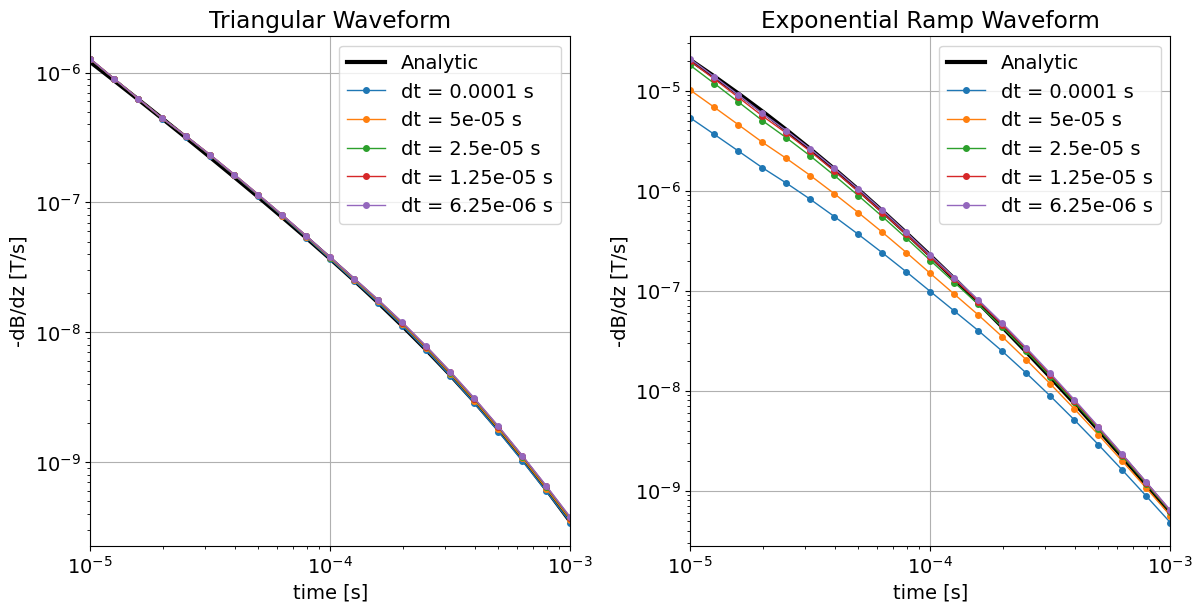

In [25]:
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_axes([0.05, 0.1, 0.4, 0.85])
ax1.loglog(time_channels, -dpred_triangular[0], 'k', lw=3)
for d in dpred_triangular[1:]:
    ax1.loglog(time_channels, -d, '-o', lw=1, markersize=4)
ax1.set_xlim((np.min(time_channels), np.max(time_channels)))
ax1.grid()
ax1.set_xlabel("time [s]")
ax1.set_ylabel("-dB/dz [T/s]")
ax1.set_title("Triangular Waveform")
ax1.legend(
    ['Analytic'] + ['dt = {} s'.format(x[0]) for x in on_time_steps_list],
    loc='upper right'
)

ax2 = fig.add_axes([0.55, 0.1, 0.4, 0.85])
ax2.loglog(time_channels, -dpred_exponential[0], 'k', lw=3)
for d in dpred_exponential[1:]:
    ax2.loglog(time_channels, -d, '-o', lw=1, markersize=4)
ax2.set_xlim((np.min(time_channels), np.max(time_channels)))
ax2.grid()
ax2.set_xlabel("time [s]")
ax2.set_ylabel("-dB/dz [T/s]")
ax2.set_title("Exponential Ramp Waveform")
ax2.legend(
    ['Analytic'] + ['dt = {} s'.format(x[0]) for x in on_time_steps_list],
    loc='upper right'
)

plt.show()